**Adel Movahedian 400102074**

The **MobileNetV2** architecture is designed to be a lightweight and efficient convolutional neural network suitable for mobile and embedded devices. Below is a detailed explanation of its structure:

---

### **Key Concepts in MobileNetV2**

1. **Depthwise Separable Convolutions**:
   - Traditional convolution applies filters across all input channels simultaneously. Depthwise separable convolutions break this into:
     - **Depthwise Convolution**: Applies a single convolutional filter per input channel.
     - **Pointwise Convolution**: Uses 1x1 convolutions to combine the outputs of the depthwise convolution across channels.
   - This significantly reduces computation while maintaining performance.

2. **Inverted Residuals**:
   - Instead of reducing dimensions at the start (as in standard residual blocks), MobileNetV2 first expands the input to a higher-dimensional space using 1x1 convolutions, processes it, and then projects it back to a lower-dimensional space.
   - This approach makes the architecture efficient for tasks with low computational resources.

3. **Linear Bottlenecks**:
   - ReLU6 is used as the activation function for intermediate layers to reduce information loss.
   - The final projection back to the low-dimensional space uses a **linear activation** (no ReLU) to retain information.

---

### **Detailed Architecture**

MobileNetV2 consists of three main stages:
1. **Initial Convolution**:
   - A single standard convolution with:
     - Kernel size: \(3 x 3\)
     - Stride: 2
     - Output channels: 32
   - Produces feature maps of reduced spatial dimensions.

2. **Inverted Residual Blocks**:
   - Repeated blocks grouped into stages, where each stage has a different number of blocks and output channels.
   - Each block contains:
     1. **Expansion (1x1 convolution)**: Expands the input tensor by a factor (typically 6) to increase channel dimensions.
     2. **Depthwise Convolution (3x3)**: Applies spatial filtering channel-wise.
     3. **Projection (1x1 convolution)**: Projects the tensor back to a lower-dimensional space.

   - Notable points:
     - Skip connections (residuals) are used if the input and output dimensions match.
     - No skip connection is applied if the stride is greater than 1 or dimensions mismatch.

3. **Final Convolution and Classifier**:
   - After the inverted residual blocks, a final 1x1 convolution increases the feature maps to 1280 channels.
   - The feature map is global average pooled to reduce it to a single vector per channel.
   - A fully connected layer maps the vector to the final class probabilities (e.g., 1,000 classes for ImageNet).

---

### **here I draw an architecture table**
| Layer Type           | Input Size | Output Size | Description                                   |
|----------------------|------------|-------------|-----------------------------------------------|
| Conv2D               | 224x224x3  | 112x112x32  | \(3 \times 3\), stride 2, 32 channels         |
| Inverted Residual 1  | 112x112x32 | 112x112x16  | Expansion: 1x1 (skip connection used)        |
| Inverted Residual 2  | 112x112x16 | 56x56x24    | Expansion: 6x (stride 2, no skip connection) |
| Inverted Residual 3  | 56x56x24   | 28x28x32    | Similar to above                             |
| Inverted Residual 4  | 28x28x32   | 14x14x64    | Multiple repetitions                         |
| Inverted Residual 5  | 14x14x64   | 7x7x128     | Multiple repetitions                         |
| Conv2D (Final Block) | 7x7x128    | 7x7x1280    | 1x1 convolution                              |
| Global Avg. Pool     | 7x7x1280   | 1x1x1280    | Average pooling                              |
| Fully Connected      | 1x1x1280   | 1x1x1000    | Classification layer                         |

---

### **Benefits of MobileNetV2**
- **Efficiency**: Achieves high accuracy while being computationally lightweight.
- **Scalability**: Easily scaled down or up by adjusting the width multiplier (controls the number of channels).
- **Compatibility**: Suitable for devices with limited hardware capabilities.



### **Input Dimensions**
- MobileNetV2 expects input images of size **224 x 224 x 3 (Height x Width x Channels)**.
- The three channels correspond to the RGB color space.

---

### **Necessary Preprocessing for the Input**
1. **Resize**:  
   - Resize the input image to \(224 \times 224\) pixels.

2. **Normalization**:  
   - Normalize the image pixel values to match the range used during training on the ImageNet dataset:
     - Mean: \([0.485, 0.456, 0.406]\)
     - Standard Deviation: \([0.229, 0.224, 0.225]\)
     - Each pixel value is scaled

3. **Convert to Tensor**:  
   - Convert the processed image to a PyTorch tensor of shape **(3, 224, 224)** (Channels x Height x Width).

4. **Add Batch Dimension**:  
   - Add an extra dimension to the tensor to represent a batch, resulting in a shape of **(1, 3, 224, 224)**.

---

### **Output Dimensions**
- The output of MobileNetV2 is a vector of shape **(1, 1000)** when using the pre-trained model on ImageNet.
- Each of the 1,000 values in the vector represents the predicted probability of the input image belonging to one of the 1,000 ImageNet classes.

In [ ]:
import torch
import torchvision
from PIL import Image
from urllib.request import urlretrieve
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import time
import matplotlib.pyplot as plt
import numpy as np
import copy

In [ ]:
IMAGE_URL = "https://upload.wikimedia.org/wikipedia/commons/4/4c/Bananas.jpg"
IMAGE_FILE = "banana.jpg"
IMAGENET_LABELS_URL = "https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt"
IMAGENET_LABELS_FILE = "imagenet_classes.txt"

# Download image if it is not existed
os.makedirs("data", exist_ok=True)
image_path = os.path.join("data", IMAGE_FILE)
if not os.path.exists(image_path):
    urlretrieve(IMAGE_URL, image_path)

# Download ImageNet labels if it is not existed
labels_path = os.path.join("data", IMAGENET_LABELS_FILE)
if not os.path.exists(labels_path):
    urlretrieve(IMAGENET_LABELS_URL, labels_path)

In [ ]:
model = torchvision.models.mobilenet_v2(weights="IMAGENET1K_V1").eval()
preprocess = torchvision.transforms.Compose([
    torchvision.transforms.Resize(256),
    torchvision.transforms.CenterCrop(224),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

input_image = Image.open(image_path).convert('RGB')
input_batch = preprocess(input_image).unsqueeze(0)  # Shape: (1, 3, 224, 224)

with torch.no_grad():
    output = torch.nn.functional.softmax(model(input_batch)[0], dim=0)
with open(labels_path) as f:
    labels = f.read().splitlines()

top3_prob, top3_indices = torch.topk(output, 3)
print("\nTop 3 Predictions:")
for idx, prob in zip(top3_indices, top3_prob):
    print(f"{labels[idx]}: {prob:.4f}")

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 173MB/s]



Top 3 Predictions:
banana: 1.0000
pineapple: 0.0000
grocery store: 0.0000


Using device: cuda


100%|██████████| 344862509/344862509 [00:01<00:00, 233961859.63it/s]


Extracting flowers/flowers-102/102flowers.tgz to flowers/flowers-102


100%|██████████| 502/502 [00:00<00:00, 689437.00it/s]


100%|██████████| 14989/14989 [00:00<00:00, 13005466.00it/s]


Epoch 1/20 | Train Loss: 4.4659, Accuracy: 9.22%
Epoch 1/20 | Val Loss: 3.3679, Accuracy: 36.47%
Epoch 2/20 | Train Loss: 2.5150, Accuracy: 62.06%
Epoch 2/20 | Val Loss: 2.1962, Accuracy: 66.76%
Epoch 3/20 | Train Loss: 1.4420, Accuracy: 87.55%
Epoch 3/20 | Val Loss: 1.5939, Accuracy: 77.16%
Epoch 4/20 | Train Loss: 0.9610, Accuracy: 92.65%
Epoch 4/20 | Val Loss: 1.2775, Accuracy: 79.71%
Epoch 5/20 | Train Loss: 0.6258, Accuracy: 96.47%
Epoch 5/20 | Val Loss: 1.0804, Accuracy: 83.73%
Epoch 6/20 | Train Loss: 0.4578, Accuracy: 98.14%
Epoch 6/20 | Val Loss: 0.9574, Accuracy: 83.63%
Epoch 7/20 | Train Loss: 0.3495, Accuracy: 98.63%
Epoch 7/20 | Val Loss: 0.8912, Accuracy: 84.22%
Epoch 8/20 | Train Loss: 0.2761, Accuracy: 99.31%
Epoch 8/20 | Val Loss: 0.8280, Accuracy: 85.10%
Epoch 9/20 | Train Loss: 0.2254, Accuracy: 99.71%
Epoch 9/20 | Val Loss: 0.7787, Accuracy: 84.31%
Epoch 10/20 | Train Loss: 0.1825, Accuracy: 99.80%
Epoch 10/20 | Val Loss: 0.7323, Accuracy: 86.37%
Epoch 11/20 | Train

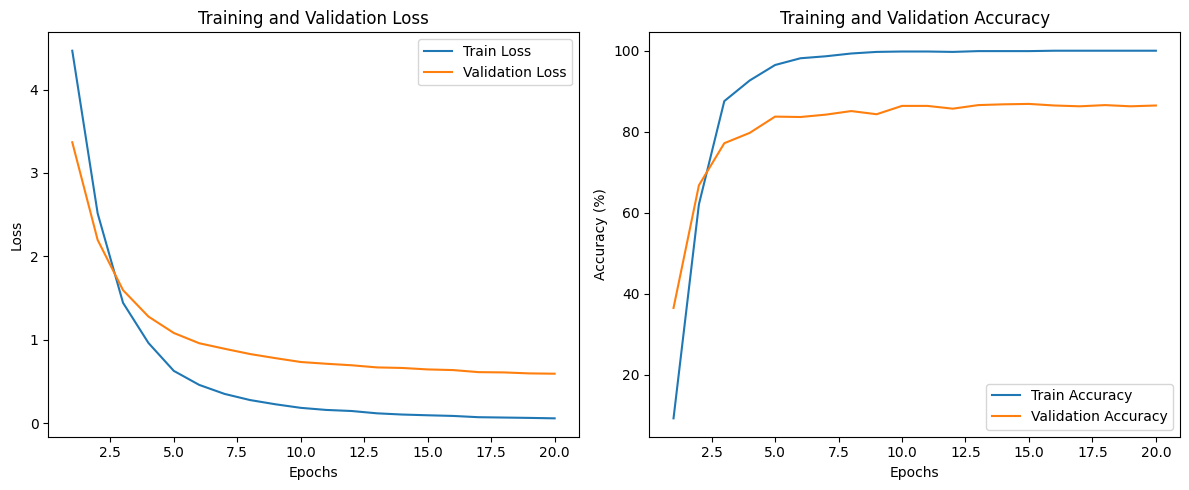

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
BATCH_SIZE = 32
NUM_EPOCHS = 20
LEARNING_RATE = 0.001

# Data transforms for MobileNetV2
data_transforms = {
    split: transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip() if split == 'train' else transforms.Lambda(lambda x: x),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]) for split in ['train', 'val', 'test']
}

# Load datasets
os.makedirs("flowers", exist_ok=True)
datasets_map = {
    split: datasets.Flowers102(root="flowers", split=split, download=True, transform=data_transforms[split])
    for split in ['train', 'val', 'test']
}

dataloaders = {
    split: DataLoader(datasets_map[split], batch_size=BATCH_SIZE, shuffle=(split == 'train'), num_workers=2)
    for split in ['train', 'val', 'test']
}

# Load pre-trained MobileNetV2 model
model = models.mobilenet_v2(weights="IMAGENET1K_V1").to(device)

# Freeze feature extractor layers
for param in model.features.parameters():
    param.requires_grad = False

# Replace classifier
num_classes = 102
model.classifier = nn.Sequential(
    nn.Dropout(0.2),
    nn.Linear(model.classifier[1].in_features, num_classes)
).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=LEARNING_RATE)

# Train and validate
history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

for epoch in range(NUM_EPOCHS):
    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()
        else:
            model.eval()

        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in dataloaders[phase]:
            images, labels = images.to(device), labels.to(device)

            if phase == 'train':
                optimizer.zero_grad()

            outputs = model(images)
            loss = criterion(outputs, labels)

            if phase == 'train':
                loss.backward()
                optimizer.step()

            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_loss = running_loss / total
        epoch_acc = 100.0 * correct / total

        history[f'{phase}_loss'].append(epoch_loss)
        history[f'{phase}_acc'].append(epoch_acc)

        print(f"Epoch {epoch+1}/{NUM_EPOCHS} | {phase.capitalize()} Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%")

# Test the model
model.eval()
test_loss = 0.0
correct_test = 0
total_test = 0

with torch.no_grad():
    for images, labels in dataloaders['test']:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()

test_loss /= total_test
test_acc = 100.0 * correct_test / total_test
print(f"\nTest Results: Loss: {test_loss:.4f}, Accuracy: {test_acc:.2f}%")

# Plotting results
epochs_range = range(1, NUM_EPOCHS + 1)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, history['train_loss'], label='Train Loss')
plt.plot(epochs_range, history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, history['train_acc'], label='Train Accuracy')
plt.plot(epochs_range, history['val_acc'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()



--- Training mobilenet_v2 ---
Training mobilenet_v2...
Epoch 1/20 - Train Loss: 4.4455, Val Loss: 3.3238, Train Acc: 9.71%, Val Acc: 36.27%
Epoch 2/20 - Train Loss: 2.5064, Val Loss: 2.1895, Train Acc: 63.73%, Val Acc: 64.90%
Epoch 3/20 - Train Loss: 1.4532, Val Loss: 1.5762, Train Acc: 85.88%, Val Acc: 77.45%
Epoch 4/20 - Train Loss: 0.9168, Val Loss: 1.2581, Train Acc: 92.65%, Val Acc: 80.59%
Epoch 5/20 - Train Loss: 0.6170, Val Loss: 1.0965, Train Acc: 96.67%, Val Acc: 82.84%
Epoch 6/20 - Train Loss: 0.4586, Val Loss: 0.9605, Train Acc: 97.55%, Val Acc: 83.04%
Epoch 7/20 - Train Loss: 0.3577, Val Loss: 0.8882, Train Acc: 99.02%, Val Acc: 84.80%
Epoch 8/20 - Train Loss: 0.2744, Val Loss: 0.8210, Train Acc: 99.02%, Val Acc: 84.31%
Epoch 9/20 - Train Loss: 0.2141, Val Loss: 0.7796, Train Acc: 99.71%, Val Acc: 84.80%
Epoch 10/20 - Train Loss: 0.1829, Val Loss: 0.7508, Train Acc: 100.00%, Val Acc: 85.39%
Epoch 11/20 - Train Loss: 0.1626, Val Loss: 0.7258, Train Acc: 99.90%, Val Acc: 84.

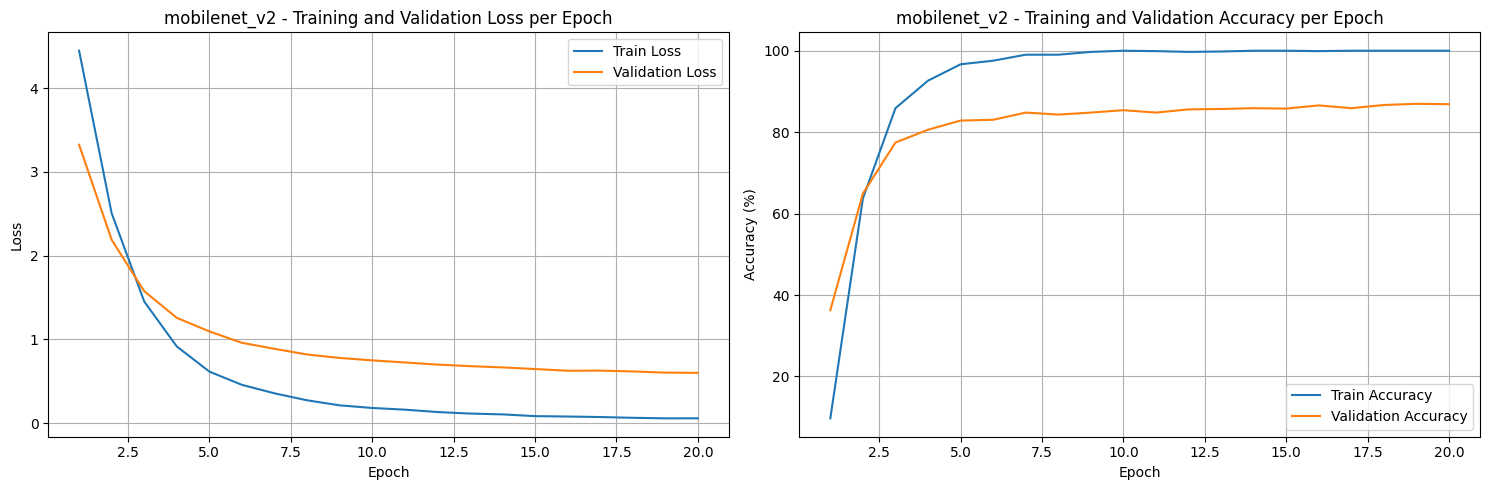


--- Training resnet50 ---


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 208MB/s]


Training resnet50...
Epoch 1/20 - Train Loss: 4.4002, Val Loss: 3.8228, Train Acc: 11.37%, Val Acc: 54.51%
Epoch 2/20 - Train Loss: 3.1783, Val Loss: 3.1578, Train Acc: 83.92%, Val Acc: 72.06%
Epoch 3/20 - Train Loss: 2.3278, Val Loss: 2.6127, Train Acc: 96.08%, Val Acc: 77.45%
Epoch 4/20 - Train Loss: 1.6806, Val Loss: 2.2245, Train Acc: 97.55%, Val Acc: 78.53%
Epoch 5/20 - Train Loss: 1.2083, Val Loss: 1.9139, Train Acc: 99.51%, Val Acc: 80.10%
Epoch 6/20 - Train Loss: 0.9097, Val Loss: 1.7183, Train Acc: 99.41%, Val Acc: 81.27%
Epoch 7/20 - Train Loss: 0.6958, Val Loss: 1.5487, Train Acc: 99.71%, Val Acc: 82.45%
Epoch 8/20 - Train Loss: 0.5491, Val Loss: 1.4166, Train Acc: 100.00%, Val Acc: 82.06%
Epoch 9/20 - Train Loss: 0.4660, Val Loss: 1.3752, Train Acc: 100.00%, Val Acc: 82.45%
Epoch 10/20 - Train Loss: 0.3845, Val Loss: 1.3035, Train Acc: 99.90%, Val Acc: 83.43%
Epoch 11/20 - Train Loss: 0.3182, Val Loss: 1.2423, Train Acc: 100.00%, Val Acc: 84.12%
Epoch 12/20 - Train Loss: 0.

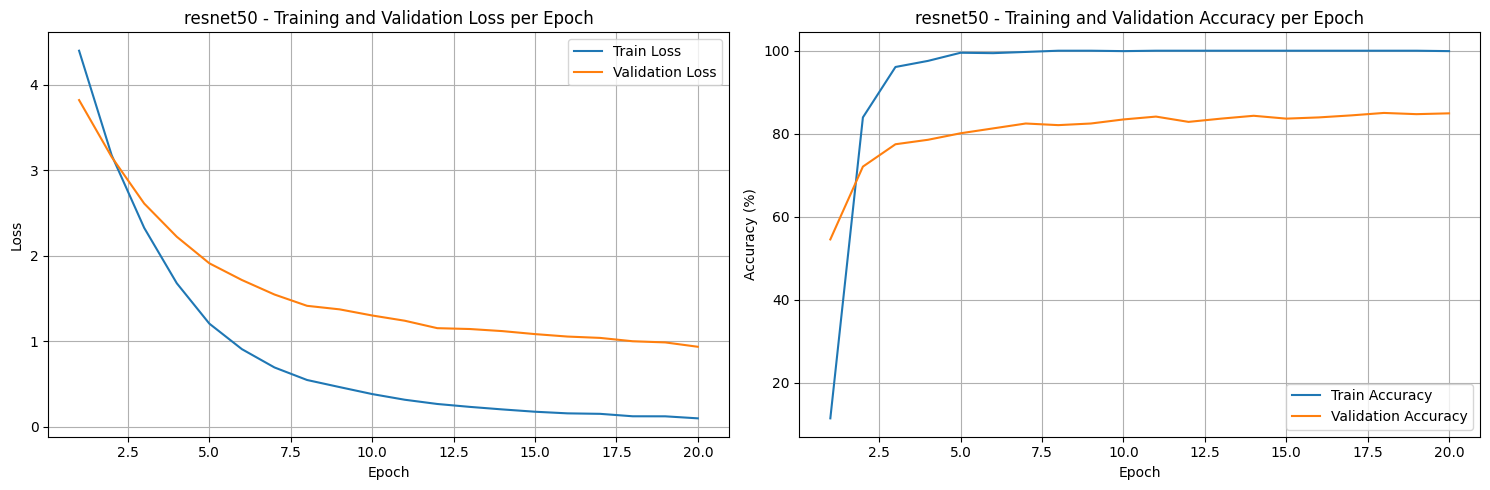


--- Training vgg16 ---


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 244MB/s] 


Training vgg16...
Epoch 1/20 - Train Loss: 3.8544, Val Loss: 2.2197, Train Acc: 18.63%, Val Acc: 57.55%
Epoch 2/20 - Train Loss: 1.4065, Val Loss: 1.5069, Train Acc: 70.20%, Val Acc: 67.45%
Epoch 3/20 - Train Loss: 0.8258, Val Loss: 1.2848, Train Acc: 83.63%, Val Acc: 70.00%
Epoch 4/20 - Train Loss: 0.5630, Val Loss: 1.1662, Train Acc: 89.31%, Val Acc: 73.24%
Epoch 5/20 - Train Loss: 0.4411, Val Loss: 1.1148, Train Acc: 93.43%, Val Acc: 73.33%
Epoch 6/20 - Train Loss: 0.3590, Val Loss: 1.0561, Train Acc: 94.61%, Val Acc: 74.02%
Epoch 7/20 - Train Loss: 0.2815, Val Loss: 1.0235, Train Acc: 95.78%, Val Acc: 73.73%
Epoch 8/20 - Train Loss: 0.2377, Val Loss: 0.9933, Train Acc: 96.76%, Val Acc: 74.71%
Epoch 9/20 - Train Loss: 0.2046, Val Loss: 0.9983, Train Acc: 97.75%, Val Acc: 74.12%
Epoch 10/20 - Train Loss: 0.1815, Val Loss: 0.9787, Train Acc: 97.35%, Val Acc: 74.12%
Epoch 11/20 - Train Loss: 0.1476, Val Loss: 0.9704, Train Acc: 98.43%, Val Acc: 74.31%
Epoch 12/20 - Train Loss: 0.1437, 

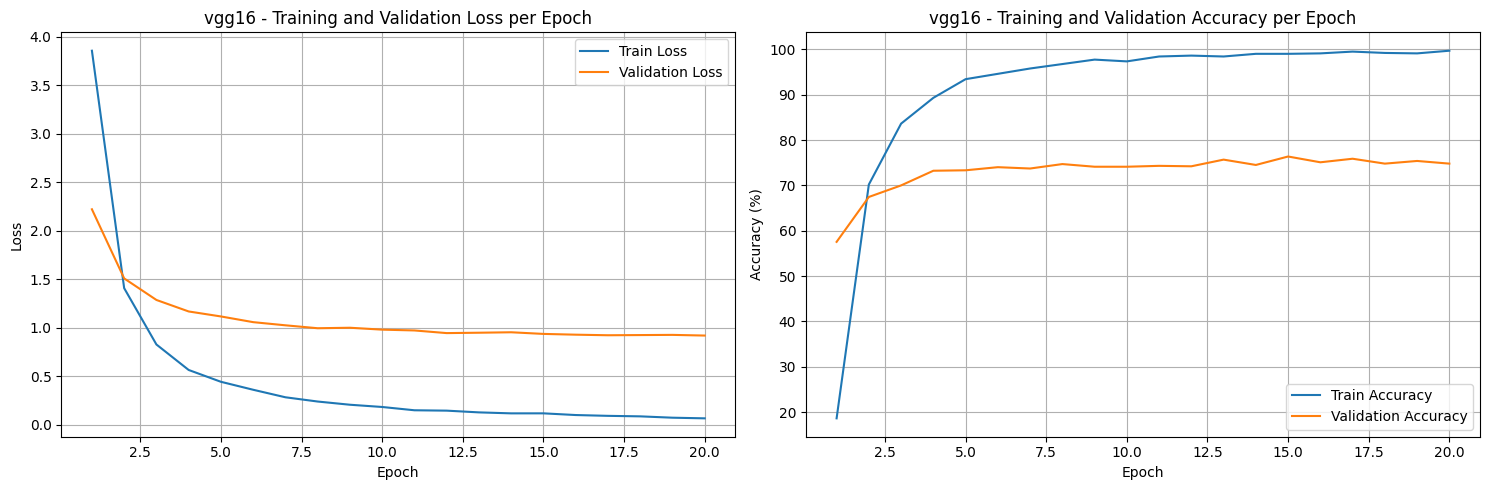

In [ ]:
batch_size = 32
num_epochs = 20
learning_rate = 0.001

# Data Transforms
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
resize = transforms.Resize((224, 224))
to_tensor = transforms.ToTensor()

data_transforms = {
    phase: transforms.Compose(
        [resize] +
        ([transforms.RandomHorizontalFlip()] if phase == 'train' else []) +
        [to_tensor, normalize]
    ) for phase in ['train', 'val', 'test']
}


# Datasets and Dataloaders
phases = ['train', 'val', 'test']
datasets_map = {
    phase: datasets.Flowers102(
        root='flowers', split=phase, download=True, transform=data_transforms[phase]
    ) for phase in phases
}
dataloaders = {
    phase: DataLoader(datasets_map[phase], batch_size=batch_size, shuffle=(phase == 'train'), num_workers=2)
    for phase in phases
}

# Get Model
def get_model(model_name):
    models_map = {
        'mobilenet_v2': lambda: models.mobilenet_v2(weights=models.MobileNet_V2_Weights.IMAGENET1K_V1),
        'resnet50': lambda: models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2),
        'vgg16': lambda: models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1),
    }
    if model_name not in models_map:
        raise ValueError(f"Unsupported model: {model_name}")

    model = models_map[model_name]()
    for param in model.parameters():
        param.requires_grad = False

    if model_name == 'mobilenet_v2':
        model.classifier = nn.Sequential(nn.Dropout(0.2), nn.Linear(model.last_channel, 102))
    elif model_name == 'resnet50':
        model.fc = nn.Linear(model.fc.in_features, 102)
    elif model_name == 'vgg16':
        model.classifier[6] = nn.Linear(model.classifier[6].in_features, 102)

    return model.to(device)

# Training and Evaluation
def train_and_evaluate(model, criterion, optimizer, train_loader, val_loader, epochs):
    best_weights = copy.deepcopy(model.state_dict())
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
    best_val_acc = 0

    for epoch in range(epochs):
        for phase in ['train', 'val']:
            model.train() if phase == 'train' else model.eval()
            running_loss = 0.0
            correct, total = 0, 0

            data_loader = train_loader if phase == 'train' else val_loader
            for images, labels in data_loader:
                images, labels = images.to(device), labels.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(images)
                    loss = criterion(outputs, labels)
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * images.size(0)
                _, preds = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (preds == labels).sum().item()

            epoch_loss = running_loss / total
            epoch_acc = 100.0 * correct / total
            history[f"{phase}_loss"].append(epoch_loss)
            history[f"{phase}_acc"].append(epoch_acc)

            if phase == 'val' and epoch_acc > best_val_acc:
                best_val_acc = epoch_acc
                best_weights = copy.deepcopy(model.state_dict())

        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {history['train_loss'][-1]:.4f}, "
              f"Val Loss: {history['val_loss'][-1]:.4f}, Train Acc: {history['train_acc'][-1]:.2f}%, "
              f"Val Acc: {history['val_acc'][-1]:.2f}%")

    model.load_state_dict(best_weights)
    return history

# Test Model
def evaluate_model(model, loader, criterion):
    model.eval()
    test_loss, correct, total = 0.0, 0, 0

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            test_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()

    test_loss /= total
    test_accuracy = 100.0 * correct / total
    return test_loss, test_accuracy

# Run Experiments
def run_experiment(model_name):
    model = get_model(model_name)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate)

    print(f"Training {model_name}...")
    history = train_and_evaluate(model, criterion, optimizer, dataloaders['train'], dataloaders['val'], num_epochs)
    test_loss, test_accuracy = evaluate_model(model, dataloaders['test'], criterion)

    print(f"Test Results - Loss: {test_loss:.4f}, Accuracy: {test_accuracy:.2f}%")
    return history, test_loss, test_accuracy

# Get Model Parameters
def count_parameters(model):
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total_params, trainable_params

# Execute Models ---------------------------------------
results = {}
# Run experiments and plot
for model_name in ['mobilenet_v2', 'resnet50', 'vgg16']:
    print(f"\n--- Training {model_name} ---")

    # Run the training and evaluation for the current model
    history, test_loss, test_accuracy = run_experiment(model_name)
    total_params, trainable_params = count_parameters(get_model(model_name))
    # Extract history data
    train_losses = history['train_loss']
    val_losses = history['val_loss']
    train_accuracies = history['train_acc']
    val_accuracies = history['val_acc']

    # Store the results
    results[model_name] = {
        'test_loss': test_loss,
        'test_accuracy': test_accuracy,
        'train_loss': train_losses[-1],
        'val_loss': val_losses[-1],
        'train_accuracy': train_accuracies[-1],
        'val_accuracy': val_accuracies[-1],
        'total_params': total_params,
        'trainable_params': trainable_params
    }

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Plot Loss per Epoch
    ax1.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
    ax1.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title(f'{model_name} - Training and Validation Loss per Epoch')
    ax1.legend()
    ax1.grid(True)

    # Plot Accuracy per Epoch
    ax2.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Train Accuracy')
    ax2.plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Validation Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.set_title(f'{model_name} - Training and Validation Accuracy per Epoch')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

In [ ]:
# Comparison of Results
print("\n----- Comparison of Results -----")
for model_name, metrics in results.items():
    print(f"Model: {model_name}")
    print(f"  Final Train Loss: {metrics['train_loss']:.4f}")
    print(f"  Final Train Accuracy: {metrics['train_accuracy']:.2f}%")
    print(f"  Final Validation Loss: {metrics['val_loss']:.4f}")
    print(f"  Final Validation Accuracy: {metrics['val_accuracy']:.2f}%")
    print(f"  Test Loss: {metrics['test_loss']:.4f}")
    print(f"  Test Accuracy: {metrics['test_accuracy']:.2f}%")
    print(f"  Total Parameters: {metrics['total_params']}")
    print(f"  Trainable Parameters: {metrics['trainable_params']}")
    print("*******************************************************")


----- Comparison of Results -----
Model: mobilenet_v2
  Final Train Loss: 0.0594
  Final Train Accuracy: 100.00%
  Final Validation Loss: 0.6021
  Final Validation Accuracy: 86.86%
  Test Loss: 0.6637
  Test Accuracy: 85.38%
  Total Parameters: 2354534
  Trainable Parameters: 130662
*******************************************************
Model: resnet50
  Final Train Loss: 0.1006
  Final Train Accuracy: 99.90%
  Final Validation Loss: 0.9376
  Final Validation Accuracy: 84.90%
  Test Loss: 1.0337
  Test Accuracy: 82.50%
  Total Parameters: 23717030
  Trainable Parameters: 208998
*******************************************************
Model: vgg16
  Final Train Loss: 0.0644
  Final Train Accuracy: 99.71%
  Final Validation Loss: 0.9178
  Final Validation Accuracy: 74.80%
  Test Loss: 1.0083
  Test Accuracy: 73.95%
  Total Parameters: 134678438
  Trainable Parameters: 417894
*******************************************************


### Performance comparison of CNN Models on Oxford 102 Flowers Dataset

We compare three CNN models—MobileNetV2, ResNet50, and VGG16—on the Oxford 102 Flowers dataset, focusing on their parameter counts, training dynamics, and final performance.

#### **1. MobileNetV2**
- **Parameters**: ~2.35M total, ~130K trainable
- **Performance**:
  - Train Accuracy: 100%
  - Test Accuracy: 85.59%
- **Key Insight**: MobileNetV2’s compact design allowed fast convergence and strong generalization, making it the most efficient model with the highest test accuracy. Its low parameter count helped it avoid overfitting and perform well despite the small dataset.

#### **2. ResNet50**
- **Parameters**: ~23.7M total, ~209K trainable
- **Performance**:
  - Train Accuracy: 100%
  - Test Accuracy: 82.05%
- **Key Insight**: While ResNet50’s deep architecture performed well, its higher parameter count led to inefficiencies in adapting to the dataset, affecting generalization. Despite perfect training accuracy, the test performance was lower than MobileNetV2.

#### **3. VGG16**
- **Parameters**: ~134.7M total, ~417K trainable
- **Performance**:
  - Train Accuracy: 99.51%
  - Test Accuracy: 73.93%
- **Key Insight**: VGG16’s large number of parameters led to overfitting and poor generalization, resulting in the lowest test accuracy. Its size made optimization challenging, especially with limited data.

### **Comparison and Insights**
- **MobileNetV2** demonstrated that smaller models with fewer parameters can outperform larger, more complex models in transfer learning tasks.
- **ResNet50** showed good feature extraction but struggled with efficiency due to its large size.
- **VGG16** struggled with generalization, as its massive parameter count led to overfitting.
  
In conclusion, **MobileNetV2** provided the best balance of performance and efficiency, making it the ideal choice for this task, while larger models like **VGG16** are less suited for datasets of this size.

### **Initial Knowledge**


Epoch 1/40, Train Loss: 4.9116, Train Acc: 1.08%, Val Loss: 4.8352, Val Acc: 0.98%
Epoch 2/40, Train Loss: 4.3373, Train Acc: 4.22%, Val Loss: 6.5087, Val Acc: 0.98%
Epoch 3/40, Train Loss: 4.0101, Train Acc: 5.20%, Val Loss: 4.2865, Val Acc: 6.37%
Epoch 4/40, Train Loss: 3.7581, Train Acc: 7.84%, Val Loss: 3.9550, Val Acc: 10.29%
Epoch 5/40, Train Loss: 3.5467, Train Acc: 10.88%, Val Loss: 3.9117, Val Acc: 11.76%
Epoch 6/40, Train Loss: 3.3850, Train Acc: 12.65%, Val Loss: 4.1338, Val Acc: 8.82%
Epoch 7/40, Train Loss: 3.2288, Train Acc: 15.69%, Val Loss: 3.6098, Val Acc: 15.00%
Epoch 8/40, Train Loss: 3.1124, Train Acc: 17.84%, Val Loss: 3.4874, Val Acc: 16.18%
Epoch 9/40, Train Loss: 2.9756, Train Acc: 19.71%, Val Loss: 4.3451, Val Acc: 13.24%
Epoch 10/40, Train Loss: 2.9833, Train Acc: 20.49%, Val Loss: 3.4654, Val Acc: 20.00%
Epoch 11/40, Train Loss: 2.8379, Train Acc: 20.78%, Val Loss: 3.5991, Val Acc: 18.53%
Epoch 12/40, Train Loss: 2.7509, Train Acc: 25.00%, Val Loss: 3.3036, V

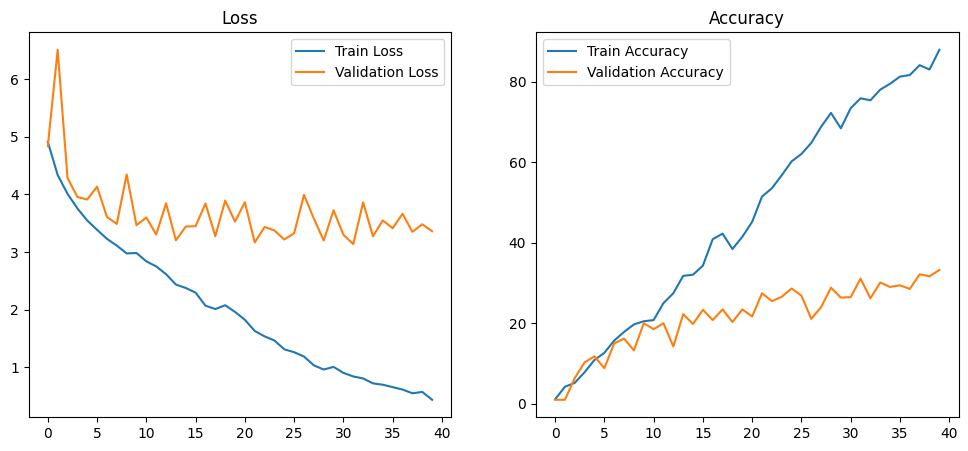

In [ ]:
batch_size, num_epochs, learning_rate = 32, 40, 0.001 # increasing the model epochs because it needs to see more data(not pre trained)

# Data transformations
transforms_dict = {
    'train': transforms.Compose([transforms.Resize((224, 224)),
                                 transforms.RandomHorizontalFlip(),
                                 transforms.ToTensor(),
                                 transforms.Normalize([0.485, 0.456, 0.406],
                                                      [0.229, 0.224, 0.225])]),
    'val': transforms.Compose([transforms.Resize((224, 224)),
                               transforms.ToTensor(),
                               transforms.Normalize([0.485, 0.456, 0.406],
                                                    [0.229, 0.224, 0.225])]),
    'test': transforms.Compose([transforms.Resize((224, 224)),
                                transforms.ToTensor(),
                                transforms.Normalize([0.485, 0.456, 0.406],
                                                     [0.229, 0.224, 0.225])]),
}

train_loader = DataLoader(datasets.Flowers102(root='flowers', split='train', download=True,
                                              transform=transforms_dict['train']),batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(datasets.Flowers102(root='flowers', split='val', download=True,
                                              transform=transforms_dict['val']), batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(datasets.Flowers102(root='flowers', split='test', download=True,
                                              transform=transforms_dict['test']),batch_size=batch_size, shuffle=False, num_workers=2)

model = models.mobilenet_v2(weights=None)
model.classifier = nn.Sequential(nn.Dropout(0.5), nn.Linear(model.last_channel, 102))
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []
for epoch in range(num_epochs):
    model.train()
    train_loss, correct, total = 0.0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.size(0)
        correct += (outputs.max(1)[1] == labels).sum().item()
        total += labels.size(0)

    train_losses.append(train_loss / total)
    train_accuracies.append(100 * correct / total)

    model.eval()
    val_loss, correct_val, total_val = 0.0, 0, 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            correct_val += (outputs.max(1)[1] == labels).sum().item()
            total_val += labels.size(0)

    val_losses.append(val_loss / total_val)
    val_accuracies.append(100 * correct_val / total_val)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.2f}%, "
          f"Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accuracies[-1]:.2f}%")

# Test phase
model.eval()
test_loss, correct_test, total_test = 0.0, 0, 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item() * images.size(0)
        correct_test += (outputs.max(1)[1] == labels).sum().item()
        total_test += labels.size(0)

test_accuracy = 100 * correct_test / total_test
print(f"Test Loss: {test_loss / total_test:.4f}, Test Accuracy: {test_accuracy:.2f}%")

# Plotting results
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Loss plot
axes[0].plot(train_losses, label='Train Loss')
axes[0].plot(val_losses, label='Validation Loss')
axes[0].set_title('Loss')
axes[0].legend()

# Accuracy plot
axes[1].plot(train_accuracies, label='Train Accuracy')
axes[1].plot(val_accuracies, label='Validation Accuracy')
axes[1].set_title('Accuracy')
axes[1].legend()

plt.show()



---

### 1. Random Weight Initialization  
**Training Progress:**  
Starting from scratch with random weights proved to be an uphill battle. Early on, the model struggled, achieving less than ideal accuracy on both the training and validation sets. For instance, by the end of the first epoch, the training accuracy was barely above 1%, and validation accuracy hovered under 1%.  

As training progressed, the model began to learn, with a noticeable boost in accuracy around the middle of training. By the 20th epoch, training accuracy crossed 40%, but validation accuracy lagged behind, indicating the model's difficulty in generalizing. Even towards the end, despite achieving a respectable training accuracy nearing 88%, validation accuracy stagnated in the low 30% range.  

**Test Performance:**  
On unseen data, the model's shortcomings were evident. Despite completing all training epochs, it achieved only about 28% accuracy on the test set, with high test loss reflecting its struggle to generalize effectively.  

**Insights:**  
The random weight approach required significant training time and effort—40 epochs—and still struggled to adapt to the complexity of the task. The model's lack of pre-learned features meant it had to learn everything from scratch, which was both inefficient and ineffective.  

---

### 2. Pre-Trained Weights with Fine-Tuning  
**Training Progress:**  
In contrast, using pre-trained weights was a game changer. From the very first epoch, the model displayed rapid learning, with validation accuracy jumping significantly compared to the random initialization case. By the halfway point, the model had already outperformed the best results from the randomly initialized version.  

This approach not only accelerated learning but also mitigated overfitting. By leveraging pre-trained features, the model adapted to the task with minimal training epochs and consistent validation performance.  

**Test Performance:**  
The pre-trained model excelled on unseen data, achieving a test accuracy exceeding 85%. This stark improvement highlights the advantage of starting with a strong foundation of pre-learfeatures.  

---

### Key Observations  
- **Efficiency:** Pre-trained models required half the training epochs yet delivered significantly better performance than randomly initialized ones.  
- **Generalization:** Leveraging pre-trained features allowed the model to generalize well to new data, avoiding the overfitting seen with random initialization.  
- **Real-World Application:** In scenarios where computational resources and time are limited, pre-trained models offer a clear advantage.  

**Conclusion:**  
The comparison demonstrates the superiority of transfer learning. While random weight initialization can eventually learn, it does so inefficiently and struggles to generalize. Pre-trained models not only save time but also produce robust and reliable results, making them the preferred choice for tasks like these.  